# Model-Based RL

In [3]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [4]:
import gym
env = gym.make('CartPole-v0')

## 하이퍼 파라미터 설정

In [6]:
# 하이퍼 파라미터
H = 8 # 은닉 게층 뉴런
learning_rate = 1e-2 # 학습률
gamma = 0.99 # 보상에 대한 discount factor
decay_rate = 0.99 # 경사의 RMSProp leacky 제곱합에 대한 decay factor
resume = False # 이전 체크포인트에서 이어서 실행할건지 여부

model_bs = 3 # 모델에서 학습 시 배치 크기
real_bs = 3 # 실제 환경에서 학습 시 배치 크기

# 모델 초기화
D = 4 # 입력값의 차원

## 정책 네트워크

In [7]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages) 
newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

## 모델 네트워크
현재 상태와 액션으로부터 다음 순서의 관찰, 보상, 완료 상태를 예측하는 다계층 신경망

In [8]:
# 모델 계층의 크기
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

## 도우미 함수

In [10]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer
        
def discount_rewards(r):
    # 보상의 1D 실수 배열을 취해서 할인된 보상을 계산
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


# 지난 상태와 액션이 주어졌을 때, 모델을 이용해서 새로운 상태를 산출한다. 
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## 정책과 모델 학습

In [11]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # True로 설정하면 관찰을 위해 모델을 사용
trainTheModel = True # 모델을 학습시킬지 여부
trainThePolicy = False # 정책을 학습시킬지 여부
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # 성능이 비교적 높아졌으면 환경을 화면에 표시하기 시작한다.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # 나중에 역전파를 위해 필요한 다양한 중간 변수를 기록한다.
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # 모델 또는 실제 환경에서 학습을 진행하고 새로운 측정값을 얻는다.
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        # 보상을 기록한다.
        # 이전 액션에 대한 보상을 얻기 위해 step() 함수 호출 뒤에 쓴다.
        drs.append(reward) 

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # 현재 에피소드의 모든 입력값, 은닉 상태, 액션 경사, 보상을 쌓는다.
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            # 배열 메모리를 리셋한다.
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                state_prevs = np.hstack([state_prevs,actions])
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts,rewards,dones])

                feed_dict={previous_state: state_prevs, true_observation: state_nexts,true_done:dones,true_reward:rewards}
                loss,pState,_ = sess.run([model_loss,predicted_state,updateModel],feed_dict)
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                
                # 경사가 너무 커지면 학습 종료
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # 모델이 100 에피소드만큼 학습되면 모델에서의 정책 학습과
                # 실제 환경에서의 모델 학습을 번갈아 가면서 수행
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
            
            if drawFromModel == True:
                # 적절한 시작점 생성
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4.000000. Reward 23.666667. action: 1.000000. mean reward 23.666667.
World Perf: Episode 7.000000. Reward 24.333333. action: 1.000000. mean reward 23.673333.
World Perf: Episode 10.000000. Reward 21.000000. action: 1.000000. mean reward 23.646600.
World Perf: Episode 13.000000. Reward 30.000000. action: 1.000000. mean reward 23.710134.
World Perf: Episode 16.000000. Reward 15.000000. action: 1.000000. mean reward 23.623033.
World Perf: Episode 19.000000. Reward 26.666667. action: 1.000000. mean reward 23.653469.
World Perf: Episode 22.000000. Reward 24.333333. action: 1.000000. mean reward 23.660268.
World Perf: Episode 25.000000. Reward 22.000000. action: 1.000000. mean reward 23.643665.
World Perf: Episode 28.000000. Reward 14.000000. action: 1.000000. mean reward 23.547228.
World Perf: Episode 31.000000. Reward 23.000000. action: 0.000000. mean reward 23.541756.
World Perf: Episode 34.000000. Reward 25.333333. action: 1.000000. mean reward 23.559672.
World Perf: 

World Perf: Episode 277.000000. Reward 26.666667. action: 0.000000. mean reward 37.088455.
World Perf: Episode 280.000000. Reward 42.666667. action: 0.000000. mean reward 36.893356.
World Perf: Episode 283.000000. Reward 16.000000. action: 1.000000. mean reward 36.480167.
World Perf: Episode 286.000000. Reward 18.666667. action: 0.000000. mean reward 36.046200.
World Perf: Episode 289.000000. Reward 37.000000. action: 0.000000. mean reward 35.788612.
World Perf: Episode 292.000000. Reward 23.333333. action: 1.000000. mean reward 36.293659.
World Perf: Episode 295.000000. Reward 32.000000. action: 0.000000. mean reward 37.883427.
World Perf: Episode 298.000000. Reward 23.333333. action: 0.000000. mean reward 37.747288.
World Perf: Episode 301.000000. Reward 21.333333. action: 1.000000. mean reward 37.421772.
World Perf: Episode 304.000000. Reward 12.333333. action: 0.000000. mean reward 36.870777.
World Perf: Episode 307.000000. Reward 37.333333. action: 0.000000. mean reward 36.651760.

World Perf: Episode 553.000000. Reward 25.000000. action: 1.000000. mean reward 85.806374.
World Perf: Episode 556.000000. Reward 44.333333. action: 1.000000. mean reward 85.663292.
World Perf: Episode 559.000000. Reward 45.333333. action: 0.000000. mean reward 85.706032.
World Perf: Episode 562.000000. Reward 61.333333. action: 0.000000. mean reward 88.053917.
World Perf: Episode 565.000000. Reward 20.333333. action: 0.000000. mean reward 86.864113.
World Perf: Episode 568.000000. Reward 17.666667. action: 0.000000. mean reward 85.446838.
World Perf: Episode 571.000000. Reward 43.333333. action: 1.000000. mean reward 84.431305.
World Perf: Episode 574.000000. Reward 37.000000. action: 0.000000. mean reward 83.456291.
World Perf: Episode 577.000000. Reward 50.000000. action: 1.000000. mean reward 82.419968.
World Perf: Episode 580.000000. Reward 52.333333. action: 1.000000. mean reward 82.063477.
World Perf: Episode 583.000000. Reward 37.000000. action: 1.000000. mean reward 81.831841.

World Perf: Episode 826.000000. Reward 78.666667. action: 0.000000. mean reward 62.999714.
World Perf: Episode 829.000000. Reward 95.000000. action: 0.000000. mean reward 62.861023.
World Perf: Episode 832.000000. Reward 89.000000. action: 0.000000. mean reward 66.788910.
World Perf: Episode 835.000000. Reward 83.000000. action: 0.000000. mean reward 66.373276.
World Perf: Episode 838.000000. Reward 60.000000. action: 0.000000. mean reward 66.150337.
World Perf: Episode 841.000000. Reward 111.666667. action: 0.000000. mean reward 66.266289.
World Perf: Episode 844.000000. Reward 102.666667. action: 0.000000. mean reward 66.041786.
World Perf: Episode 847.000000. Reward 38.000000. action: 0.000000. mean reward 66.419212.
World Perf: Episode 850.000000. Reward 79.333333. action: 0.000000. mean reward 66.037392.
World Perf: Episode 853.000000. Reward 109.000000. action: 1.000000. mean reward 65.879639.
World Perf: Episode 856.000000. Reward 107.000000. action: 1.000000. mean reward 67.477

World Perf: Episode 1096.000000. Reward 66.666667. action: 0.000000. mean reward 90.480774.
World Perf: Episode 1099.000000. Reward 123.000000. action: 0.000000. mean reward 90.297668.
World Perf: Episode 1102.000000. Reward 100.333333. action: 0.000000. mean reward 91.628349.
World Perf: Episode 1105.000000. Reward 53.000000. action: 0.000000. mean reward 90.843636.
World Perf: Episode 1108.000000. Reward 103.333333. action: 1.000000. mean reward 91.399117.
World Perf: Episode 1111.000000. Reward 133.000000. action: 0.000000. mean reward 94.566925.
World Perf: Episode 1114.000000. Reward 111.666667. action: 0.000000. mean reward 93.962280.
World Perf: Episode 1117.000000. Reward 90.333333. action: 0.000000. mean reward 95.686119.
World Perf: Episode 1120.000000. Reward 105.333333. action: 1.000000. mean reward 95.090813.
World Perf: Episode 1123.000000. Reward 71.666667. action: 0.000000. mean reward 95.947334.
World Perf: Episode 1126.000000. Reward 76.666667. action: 0.000000. mean 

World Perf: Episode 1360.000000. Reward 150.666667. action: 0.000000. mean reward 127.778542.
World Perf: Episode 1363.000000. Reward 187.333333. action: 1.000000. mean reward 130.050873.
World Perf: Episode 1366.000000. Reward 143.000000. action: 0.000000. mean reward 128.971176.
World Perf: Episode 1369.000000. Reward 168.666667. action: 0.000000. mean reward 128.197983.
World Perf: Episode 1372.000000. Reward 196.333333. action: 0.000000. mean reward 130.678741.
World Perf: Episode 1375.000000. Reward 142.000000. action: 0.000000. mean reward 131.569763.
World Perf: Episode 1378.000000. Reward 140.333333. action: 1.000000. mean reward 133.320328.
World Perf: Episode 1381.000000. Reward 181.666667. action: 0.000000. mean reward 132.610184.
World Perf: Episode 1384.000000. Reward 145.000000. action: 1.000000. mean reward 131.638947.
World Perf: Episode 1387.000000. Reward 143.333333. action: 1.000000. mean reward 130.647629.
World Perf: Episode 1390.000000. Reward 54.333333. action: 0

World Perf: Episode 1624.000000. Reward 200.000000. action: 1.000000. mean reward 191.904602.
World Perf: Episode 1627.000000. Reward 200.000000. action: 0.000000. mean reward 192.131058.
World Perf: Episode 1630.000000. Reward 186.000000. action: 0.000000. mean reward 192.651016.
World Perf: Episode 1633.000000. Reward 191.000000. action: 1.000000. mean reward 193.691101.
World Perf: Episode 1636.000000. Reward 155.333333. action: 1.000000. mean reward 192.019089.
World Perf: Episode 1639.000000. Reward 140.000000. action: 1.000000. mean reward 192.592773.
World Perf: Episode 1642.000000. Reward 168.333333. action: 0.000000. mean reward 192.521118.
World Perf: Episode 1645.000000. Reward 200.000000. action: 1.000000. mean reward 193.749252.
World Perf: Episode 1648.000000. Reward 190.333333. action: 0.000000. mean reward 194.813904.
World Perf: Episode 1651.000000. Reward 167.333333. action: 0.000000. mean reward 195.597672.
World Perf: Episode 1654.000000. Reward 140.666667. action: 

World Perf: Episode 1888.000000. Reward 200.000000. action: 1.000000. mean reward 216.365402.
World Perf: Episode 1891.000000. Reward 200.000000. action: 1.000000. mean reward 217.026566.
World Perf: Episode 1894.000000. Reward 200.000000. action: 1.000000. mean reward 217.713257.
World Perf: Episode 1897.000000. Reward 200.000000. action: 1.000000. mean reward 217.776016.
World Perf: Episode 1900.000000. Reward 200.000000. action: 1.000000. mean reward 218.410446.
World Perf: Episode 1903.000000. Reward 180.333333. action: 1.000000. mean reward 218.990158.
World Perf: Episode 1906.000000. Reward 200.000000. action: 1.000000. mean reward 219.527649.
World Perf: Episode 1909.000000. Reward 200.000000. action: 0.000000. mean reward 220.092026.
World Perf: Episode 1912.000000. Reward 198.333333. action: 1.000000. mean reward 220.689697.
World Perf: Episode 1915.000000. Reward 200.000000. action: 1.000000. mean reward 221.259537.
World Perf: Episode 1918.000000. Reward 192.000000. action: 

World Perf: Episode 2152.000000. Reward 189.666667. action: 0.000000. mean reward 228.853653.
World Perf: Episode 2155.000000. Reward 200.000000. action: 0.000000. mean reward 229.266968.
World Perf: Episode 2158.000000. Reward 200.000000. action: 0.000000. mean reward 229.690750.
World Perf: Episode 2161.000000. Reward 200.000000. action: 0.000000. mean reward 230.080368.
World Perf: Episode 2164.000000. Reward 200.000000. action: 0.000000. mean reward 230.522934.
World Perf: Episode 2167.000000. Reward 200.000000. action: 0.000000. mean reward 230.974838.
World Perf: Episode 2170.000000. Reward 200.000000. action: 0.000000. mean reward 228.924484.
World Perf: Episode 2173.000000. Reward 200.000000. action: 0.000000. mean reward 229.364685.
World Perf: Episode 2176.000000. Reward 200.000000. action: 1.000000. mean reward 229.730240.
World Perf: Episode 2179.000000. Reward 200.000000. action: 0.000000. mean reward 230.168869.
World Perf: Episode 2182.000000. Reward 200.000000. action: 

World Perf: Episode 2416.000000. Reward 200.000000. action: 0.000000. mean reward 244.795242.
World Perf: Episode 2419.000000. Reward 200.000000. action: 1.000000. mean reward 244.894409.
World Perf: Episode 2422.000000. Reward 188.333333. action: 0.000000. mean reward 244.870834.
World Perf: Episode 2425.000000. Reward 200.000000. action: 1.000000. mean reward 244.976685.
World Perf: Episode 2428.000000. Reward 200.000000. action: 1.000000. mean reward 245.064957.
World Perf: Episode 2431.000000. Reward 200.000000. action: 1.000000. mean reward 245.357040.
World Perf: Episode 2434.000000. Reward 200.000000. action: 0.000000. mean reward 245.501816.
World Perf: Episode 2437.000000. Reward 200.000000. action: 1.000000. mean reward 245.669785.
World Perf: Episode 2440.000000. Reward 200.000000. action: 1.000000. mean reward 245.829849.
World Perf: Episode 2443.000000. Reward 200.000000. action: 0.000000. mean reward 245.925903.
World Perf: Episode 2446.000000. Reward 200.000000. action: 

## 모델의 대표성 확인

/Users/ohyeji/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/Users/ohyeji/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/Users/ohyeji/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

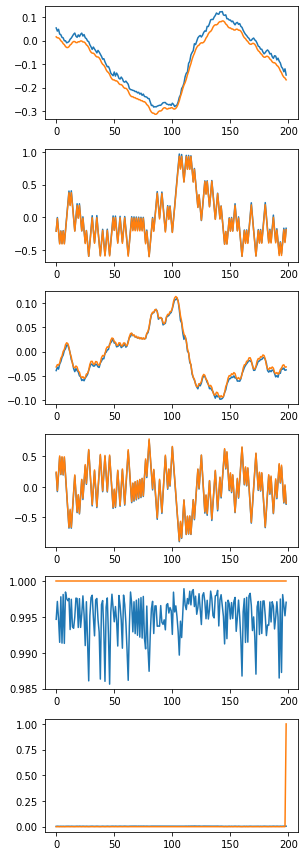

In [12]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()